In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import time
import copy
import linecache
import gzip
import pickle
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
from torch.nn import functional as F

import sys, argparse, os
import numpy as np
import random
import sys, argparse, os

import torch.nn.functional as F
import torch.utils.data as torchdata

import sys
sys.path.insert(0, '../')
sys.path.append("/scratch2/ml_flood/mlflood/")
from pathlib import Path
from mlflood.conf import PATH_DATA
from mlflood.conf import rain_const, waterdepth_diff_const
import h5py
import pandas as pd

from torch.utils.tensorboard import SummaryWriter
from mlflood.utils import new_log
from models.utae import UTAE
from models.CNNrolling import CNNrolling
from models.unet3d import UNet3D
from models.unet import UNet
from models.unet_bay import UNet_bay
from dataset import load_test_dataset, dataloader_args_test

from training import *
#from developing_suite4 import *

3.4.0
3.4.0


In [2]:
path_exp = "/scratch2/ml_flood/data/checkpoints/709/cluster/unet_l1/experiment_0/"
path_exp = "/scratch2/ml_flood/data/checkpoints/709/unet_bay_temp/experiment_0/"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)
args = []   

Using:  cuda


In [4]:
parser = argparse.ArgumentParser(description="evaluation")
parser.add_argument("--catchment_kwargs", default='./default_catchment_kwargs.yml', type=str, 
                    help="path to catchment kwargs saved in yml file")

exp_hp = ['--catchment_kwargs=../mlflood/exp_yml/exp_unet_bay.yml']
args = parser.parse_args(exp_hp)

with open(args.catchment_kwargs) as file:
    catchment_kwargs = yaml.full_load(file)
    
# Always in eval mode
catchment_kwargs['fix_indexes'] = True 

In [5]:
dataloaders = {}
dataset = load_test_dataset(catchment_kwargs)
                                                             
dataloaders["test"] = dataloader_args_test(dataset, catchment_num = catchment_kwargs['num'])
dataset_test = dataloaders["test"]

Load file: /scratch2/ml_flood/data/generated_datasets/709-test.h5


In [6]:
model = UNet_bay(args)  
file_path1 = path_exp + "model.pth.tar"
model.load_state_dict(torch.load(file_path1))
model.cuda()

UNet_bay(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(27, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, m

In [7]:
from evaluation import predict_event 

event_num = 0
start_ts = 5
# timestep = 12

pred_cnn, gt_cnn, mask_cnn = predict_event(model, dataset, event_num, 'unet', start_ts=5, ar = False, T = None)

  0%|                                                                                                          | 0/43 [00:00<?, ?it/s]/scratch2/anaconda3/envs/MLflood/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:58<00:00,  1.35s/it]


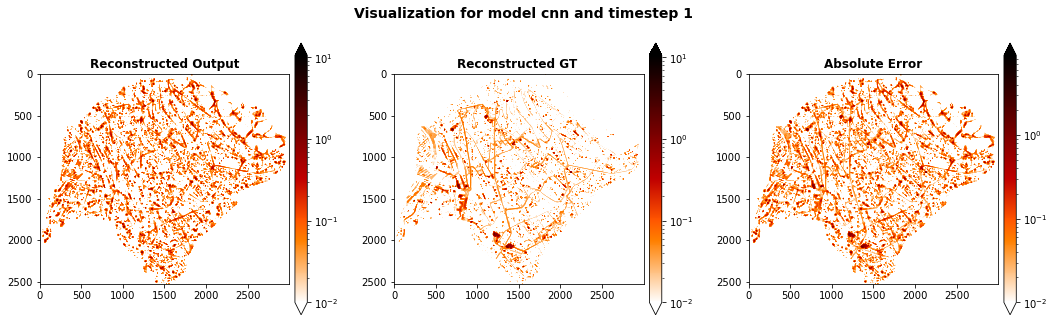

In [8]:
zoom = [500,1000,500,1000]
save_folder = "/scratch2/ml_flood/data/checkpoints/709/cluster/utae_L1/experiment_0/results/c_recons/"
plot_answer_sample(pred_cnn, gt_cnn, mask_cnn, ts=1, zoom=None, show_diff=False, global_scale=True, save_folder = None, model_name = 'cnn')

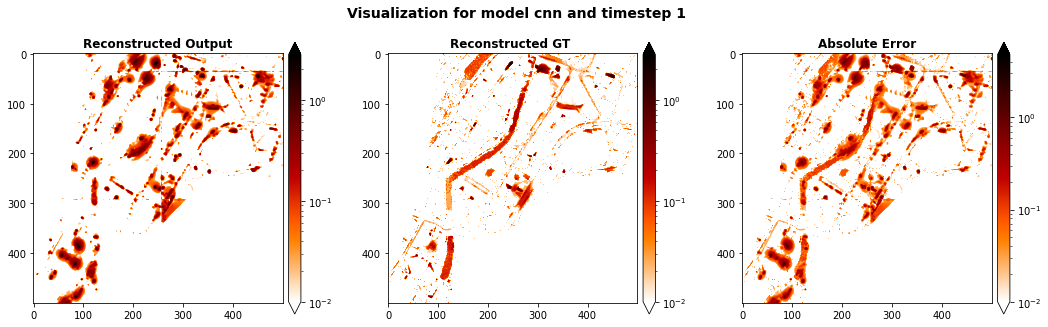

In [9]:
zoom = [1500,2000,0,500]
plot_answer_sample(pred_cnn, gt_cnn, mask_cnn, ts=1, zoom=zoom, show_diff=False, global_scale=True, save_folder = None, model_name = 'cnn')

In [11]:
lims = (0.1,0.2, 0.5, 1)
pred_ts = 12

data_cnn = boxplot_mae(pred_cnn, gt_cnn, mask_cnn, lims=lims, pred_ts = pred_ts)

Negative waterdept value: -0.22642280161380768


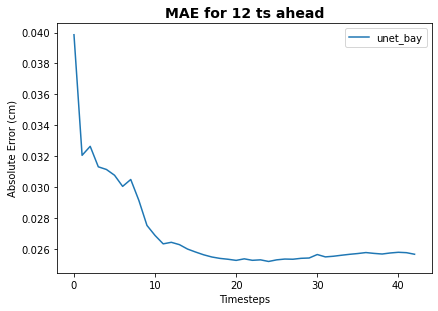

In [19]:
mae_cnn = mae_event(pred_cnn, gt_cnn, mask_cnn)

maes = [mae_cnn]

labels = ['unet_bay']
plot_maes(maes, labels, start_ts=0, save_folder = None, name = '12_ts_ahead', title = "MAE for 12 ts ahead")